# Recovering output with intermediate symmetry by constraining order parameters
In this example, we will show that by constraining the learnable order parameter, we can recover output with symmetry that is intermediate between input and target output symmetries.

In [1]:
import torch
import torch_geometric as tg
import e3nn
from e3nn import rs, o3
from e3nn.networks import GatedConvParityNetwork
from e3nn.point.message_passing import Convolution
import e3nn.point.data_helpers as dh
from e3nn.tensor.spherical_tensor import SphericalTensor
import math
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

device = "cuda:1"

In [2]:
import pymatgen
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

### Same set up as before

In [3]:
struct_221_primitive = Structure.from_file('structures/221_orig.cif')
struct_221 = Structure.from_file("structures/221_anon.cif")
struct_62 = Structure.from_file(filename="structures/62_anon_sorted.cif")

rlatt = torch.tensor(struct_221_primitive.lattice.reciprocal_lattice.abc)

# Rotate space group 62 setting lattice to match Cartesian coordinates of cubic setting
new_lattice = o3.rot_z(np.pi / 4.).T @ struct_221.lattice.matrix

struct_221 = Structure(new_lattice, struct_221.species, struct_221.frac_coords)
struct_62 = Structure(new_lattice, struct_62.species, struct_62.frac_coords)

print(struct_221.lattice)
lat = 4.055964

4.055964 4.055964 0.000000
-4.055964 4.055964 0.000000
0.000000 0.000000 8.112000


In [4]:
atom_types_list = ['A', 'B', 'X']
atom_indices = [atom_types_list.index(str(s.species)[0]) for s in struct_221]  # Remove decorators

### This time we only use a pseudovector order parameter according to our previous notebook's findings.

In [5]:
Rs_order_param = [(1, 1, 1)]  # 2020.08.25 ONLY NEED PSEUDOVECTOR (per atom)
A_input = torch.tensor([1., 0., 0.]).unsqueeze(0)
B_input = torch.tensor([0., 1., 0.]).unsqueeze(0)
X_input = torch.tensor([0., 0., 1.]).unsqueeze(0)
atom_inputs = [A_input, B_input, X_input]
Rs_in = [(3, 0, 1)] + Rs_order_param # 3 atom types + order parameters
N = len(struct_221)
zeros = torch.zeros(N - 4, rs.dim(Rs_order_param))
# order_param_input = torch.zeros(20, rs.dim(Rs_order_param))
order_param_input = torch.zeros(2, rs.dim(Rs_order_param) - 1) # Remove z and same across pairs
# order_param_input.to(device)
order_param_input.requires_grad = True

lmax = 6

Rs_out = [(1, 1, -1)]
r_max = 3.5

In [6]:
def create_features(order_param_input):
    # Modify for z
    new_order_param = torch.stack([order_param_input[:, 0].repeat(2),
                                   torch.zeros(4), 
                                   order_param_input[:, 1].repeat(2)], dim=-1)
    order_param = torch.cat([zeros, new_order_param], dim=0)

    N = len(atom_indices)
    all_atom_types = torch.cat([
        atom_inputs[i] for i in atom_indices
    ], dim=0)  # [N, atom_types]

    return torch.cat([all_atom_types, order_param], dim=-1)

In [7]:
relative_vecs_62 = []
for i, site in enumerate(struct_221):
    sites = struct_62.get_sites_in_sphere(site.coords, 1., include_index=True, include_image=True)
    sorted_sites = sorted(sites, key=lambda x: x[1])
    r = sorted_sites[0][0].coords - site.coords
    relative_vecs_62.append(r)
relative_vecs_62 = np.stack(relative_vecs_62, axis=0)
pos = torch.tensor(struct_221.cart_coords, dtype=torch.float64)
relative_vecs_62 = torch.tensor(relative_vecs_62, dtype=torch.float64)
print("max distortion in Angstroms (62): ", relative_vecs_62.norm(2, -1).max())

max distortion in Angstroms (62):  tensor(0.2565)


In [8]:
model_kwargs = {
    'convolution': Convolution,
    'Rs_in': Rs_in, 'Rs_out': Rs_out,
    'mul': 6, 'lmax': lmax, 'layers': 3,
    'max_radius': r_max,  # From dataset
    'number_of_basis': 10,
}

model = GatedConvParityNetwork(**model_kwargs)

In [9]:
opt = torch.optim.Adam(model.parameters(), 1e-2)
order_opt = torch.optim.Adam([order_param_input], 1e-2)

In [10]:
model.load_state_dict(torch.load('spacegroup_62_model_overfit.torch')['model'])

<All keys matched successfully>

In [11]:
# # Used to create overfit model
# max_iter = 31

# model.to(device)

# for i in range(max_iter):
#     features = create_features(order_param_input)
#     data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
#     data.to(device)
#     output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
#     loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean()
#     if i % 10 == 0:
#         print("model update: ", loss)
#     opt.zero_grad()
#     loss.backward()
#     opt.step() 

# torch.save({'model': model.state_dict(), 'order_param_input': order_param_input},
#            'spacegroup_62_model_overfit.torch')

In [12]:
max_iter = 101

model.to(device)

for i in range(max_iter):
    # Update model
    order_param_input.to('cpu')
    features = create_features(order_param_input)
    data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
    data.to(device)
    output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
    loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean()
    if i % 10 == 0:
        print("model update: ", loss)
    opt.zero_grad()
    loss.backward()
    opt.step() 
    
    # Update input
    order_param_input.to('cpu')
    features = create_features(order_param_input)
    data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
    data.to(device)
    output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
    loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean().cpu() + 1e-2 * order_param_input.abs().mean()
    if i % 10 == 0:
        print("order param update: ", loss)
    order_opt.zero_grad()
    loss.backward()
    order_opt.step() 

model update:  tensor(0.0676, device='cuda:1', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0676, grad_fn=<AddBackward0>)
model update:  tensor(0.0423, device='cuda:1', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0379, grad_fn=<AddBackward0>)
model update:  tensor(0.0424, device='cuda:1', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0294, grad_fn=<AddBackward0>)
model update:  tensor(0.0449, device='cuda:1', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0476, grad_fn=<AddBackward0>)
model update:  tensor(0.0318, device='cuda:1', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0353, grad_fn=<AddBackward0>)
model update:  tensor(0.0320, device='cuda:1', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0299, grad_fn=<AddBackward0>)
model update:  tensor(0.0332, device='cuda:1', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0335, grad_fn=<AddBackward0>)
model update:  tensor(0.0295, device='cuda:1', grad_fn=<MeanBackward0>)
orde

In [13]:
torch.save({'model': model.state_dict(), 'order_param_input': order_param_input},
           'spacegroup_74_from_62_model_1_e.torch')

In [14]:
order_param_input.to('cpu')
features = create_features(order_param_input)
# print(features)
data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
data.to(device)
output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)

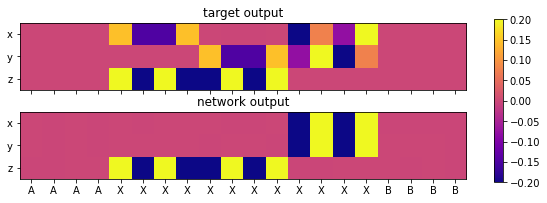

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 3))
bound = 0.2
mappable = ax[0].imshow(data.y.cpu().detach().numpy().T, cmap="plasma", vmax=bound, vmin=-bound)
ax[1].imshow(output[:, [2, 0, 1]].cpu().detach().numpy().T, cmap="plasma", vmax=bound, vmin=-bound)
sites = [str(s.species)[0] for s in struct_62]

ax[0].set_title('target output')
ax[1].set_title('network output')

ax[0].set_xticks(range(len(sites)))
ax[0].set_xticklabels([''] * len(sites))
ax[1].set_xticks(range(len(sites)))
ax[1].set_xticklabels(sites)

ax[0].set_yticks(range(3))
ax[1].set_yticks(range(3))
ax[0].set_yticklabels(['x', 'y', 'z'])
ax[1].set_yticklabels(['x', 'y', 'z'])
fig.colorbar(mappable, ax=ax)

In [16]:
new_struct = Structure(new_lattice, struct_221.species,
                       struct_221.cart_coords + output.cpu()[:, [2, 0, 1]].detach().numpy(),
                       coords_are_cartesian=True)
new_struct.to(filename='intermediate_struct_in_space_group_74.cif')

In [17]:
pga = SpacegroupAnalyzer(new_struct)
pga.get_space_group_number()

74